### Unsupervised Machine Learning Approach to Anomaly Detection in Time Series Data

Emani Hunter | Team Argonne

**The code following the sponsor provided code has been reproduced from: https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb**

**Credits/Reference/Citation:** V., Venelin, _Time Series Anomaly Detection_, (2019), GitHub Repository, https://github.com/curiousily/Deep-Learning-For-Hackers

### Method: LSTM Autoencoder

- Where was this algorithm/ idea found?
    - The idea of LSTM based Anomaly Detection was found during a literature review. The scientific journal that was found during the literature review process can be found here: https://arxiv.org/pdf/2006.03193.pdf, titled 'LSTM-based Anomaly Detection for Non-linear Dynamical System'.
        - The paper discusses using LSTM to capture complex temporal changes of a time sequence and make predictions in a multi-step process.
        - For the anomaly detection process, the researchers attempted to apply a LAAP (Local Average with Adaptive Parameters) algorithm to extract numerical features of a time series sequence locally to estimate an upcoming anomaly.
- What is an LSTM Autoencoder? 
    - An LSTM Autoencoder is a Recurrent Neural Network (RNN) that is very commonly used on sequential or time series data.
        - Because LSTM Autoencoders are RNNs this means that they take in data and try to reconstruction themselves based on previous outputs to be used as inputs to continually generate the next new output of the sequence.
        - One may think of this as a feedback loop, where one data point depends upon the previous data point and with autoencoders we are trying to incorporate the dependencies between the data points. 
    - LSTM models automatically extract the effects of past events/calculations to yield a prediction for the additional data points. 
- How can LSTM Autoencoders work for Anomaly Detection?
    - The Autoencoder can train itself to learn patterns that exist in the data. The model can look at the patterns of previous values over a time frame and predict the behavior for the next time frame/set of times. With this predicted data, the mean absolute error can be calculate from the true data and a threshold can be set to detect and classify outliers/ anomalous points.

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import pickle
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.random import set_seed

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

In [296]:
seed(1)
set_seed(2)

First, lets unpack the data provided by Argonne National Laboratory. _**Note: The following code was also provided by ANL.**_

In [297]:
Kol=loadmat('Kol_Label.mat')
w=Kol['w'] #This data is separated every 5 time units
state=Kol['state'].squeeze()
state=state[1:]
[M,N1,N2]=w.shape
w=w.reshape(M,-1)
w=w[1:]
print("Features of the data: ", list(Kol.keys())[3:])

Features of the data:  ['w', 'KE', 'state']


The data is considered 'fluid dynamics' data. More specifically, it represents the Kolmogorov flow of a fluid. The data contains 3 features:
- w
    - 'w' is the vorticity, or the measure of the rotation occuring in the fluid.
    - This feature is most important to our anomaly detection process
    
- KE
    - 'KE' is enstropy, or an analog of how much rotational energy there is. (This is not exactly 'Kinetic Energy'
    - This feature will be discarded, as it is not relevant to which anomalies we would like to detect.
    
- state
    - 'state' is a class label that was set given a specific threshold. If the KE is greater than 60, the state = 1 (meaning the data point is anomalous), otherwise, the state = 0 (meaning the data point is normal). This threshold was set by ANL.

Below is a plot showing a compressed version of the spikes of the vorticity (blue line). The red line is a 'window' showing the points that are in an anomolous state/class. An interesting note to point out is, at an instance, when L2 norm of the vorticity is calculated, as one measures the quantity over time spikes or burst conditions can be seen. _**Note: The following code was also provided by ANL.**_

Normalized w:  [53.51811589 54.60877617 53.46717475 ... 54.65259779 53.31396045
 54.88685817]


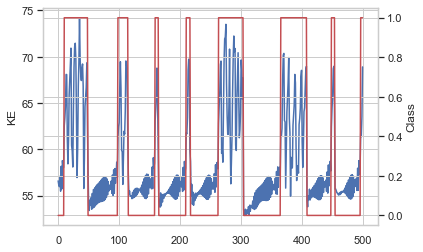

In [298]:
fix,ax=plt.subplots()
ax.plot(np.linalg.norm(w[500:1000,:],axis=1)) 
ax.set_ylabel('KE')
ax2=ax.twinx()
ax2.plot(state[500:1000],'r-')
ax2.set_ylabel('Class')
print("Normalized w: ", np.linalg.norm(w, axis=1))

Let's take a look at the shape of the normalized vorticity, or 'w'.

In [299]:
w_norm = np.linalg.norm(w, axis=1)
w_norm.shape

(99980,)

To make things easier to see, we can create a dataframe with an arbitrary timestamp following the 5 units of separation mentioned in the above code comments.

In [301]:
kol_df = pd.DataFrame()
kol_df['timestamp'] = np.linspace(0, 5, w_norm.shape[0]) #arbitrary timestamp following 5 units of separation
kol_df['w'] = w_norm
kol_df = kol_df.set_index('timestamp')
kol_df['class'] = state

normal_w = kol_df[kol_df['class'] == 0]
normal_w = normal_w.drop('class', axis = 1) # create dataset only containing the normal points to take a look

anomaly_w = kol_df[kol_df['class'] == 1]
anomaly_w = anomaly_w.drop('class', axis = 1) # create dataset only containing anomalous points to take a look

kol_df = kol_df.drop('class', axis=1)
kol_df

w
timestamp           
0.00000    53.518116
0.00005    54.608776
0.00010    53.467175
0.00015    54.052605
0.00020    54.248143
...              ...
4.99980    54.160427
4.99985    53.263051
4.99990    54.652598
4.99995    53.313960
5.00000    54.886858

[99980 rows x 1 columns]

#### Preprocessing

Split the data so that we have 95% of the data as the training set and 5% of the data as the testing set.

In [302]:
train_size = int(len(kol_df) * 0.95)
test_size = len(kol_df) - train_size
train = kol_df.iloc[0:train_size] # grab a subset of the data for the training
test = kol_df.iloc[train_size:len(kol_df)] # grab a subset of the data for the testing
print("Training set shape: ", train.shape,"Testing set shape: ", test.shape)

Training set shape:  (94981, 1) Testing set shape:  (4999, 1)


Now that we have the train and test subsets, we can scale and transform the 'w' values.

In [303]:
scaler = StandardScaler()
scaler = scaler.fit(train[['w']])

train['w'] = scaler.transform(train[['w']])
test['w'] = scaler.transform(test[['w']])

A function is created to create the training and testing sets to be used for the LSTM model. The LSTM model takes in specific subsequences, so this helper function will help to create that sequence with 3 dimensions.

In [304]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps]) 
    return np.array(Xs), np.array(ys)

In [305]:
TIME_STEPS = 32 # time step to predict from the previous 32 times

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['w']], train['w'], TIME_STEPS)
X_test, y_test = create_dataset(test[['w']], test['w'], TIME_STEPS)

print(X_train.shape)
print(X_test.shape)

(94949, 32, 1)
(4967, 32, 1)


#### Define the LSTM Model

We then define the LSTM model that takes the subsequences created above as input and outputs a sequence of the same size and shape

In [306]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1])) #copies values from the first 32 time step vals
model.add(keras.layers.LSTM(units=64, return_sequences=True)) #returns sequence after doing param optimization
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2]))) #provides the same amount of units we passed in as the input, asking model to look at 32 timesteps and predict the same sequence
model.compile(loss='mae', optimizer='adam')

In [307]:
history = model.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/10
2671/2671 [==============================] - 62s 20ms/step - loss: 0.6392 - val_loss: 0.6418
Epoch 2/10
2671/2671 [==============================] - 49s 18ms/step - loss: 0.6305 - val_loss: 0.6387
Epoch 3/10
2671/2671 [==============================] - 49s 18ms/step - loss: 0.6286 - val_loss: 0.6373
Epoch 4/10
2671/2671 [==============================] - 57s 21ms/step - loss: 0.6278 - val_loss: 0.6365
Epoch 5/10
2671/2671 [==============================] - 49s 18ms/step - loss: 0.6269 - val_loss: 0.6360
Epoch 6/10
2671/2671 [==============================] - 52s 19ms/step - loss: 0.6262 - val_loss: 0.6355
Epoch 7/10
2671/2671 [==============================] - 55s 21ms/step - loss: 0.6258 - val_loss: 0.6352
Epoch 8/10
2671/2671 [==============================] - 58s 22ms/step - loss: 0.6254 - val_loss: 0.6340
Epoch 9/10
2671/2671 [==============================] - 55s 21ms/step - loss: 0.6251 - val_loss: 0.6341
Epoch 10/10
2671/2671 [==============================] - 55s 21m

Plot the train and test loss over the 10 epochs that was ran.

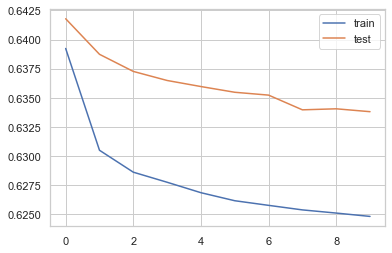

In [308]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

To help find the anomalies, we can calculate the train MAE (Mean Absolute Error) loss on the predicted values and the true data values.

In [309]:
X_train_pred = model.predict(X_train) #Predicting

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

We can then plot the distribution of the MAE loss for each data point.

/Users/emanihunter/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


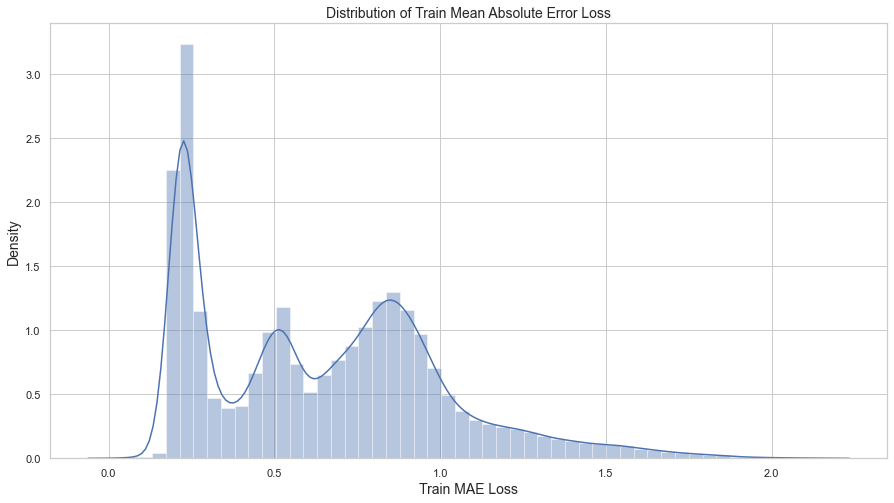

In [310]:
plt.figure(figsize=(15,8))
sns.set_theme(style='whitegrid')
sns.distplot(train_mae_loss, bins=50, kde=True);
plt.plot(np.mean(np.abs(X_train_pred - X_train)))
plt.title('Distribution of Train Mean Absolute Error Loss', fontsize=14)
plt.xlabel('Train MAE Loss', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('distplot.png', dpi=300)

Looking at the distribution of the train MAE, we can pick a threshold where the train MAE loss does not have much of any 'large' change or 'spike'. The last spike in the train MAE loss can be approximated to be ~0.85. So, we can pick a static threshold of 0.85 to help classify the anomalous points that have a loss greater than that threshold.

Below, we can calculate the test MAE loss to classify the outliers.

In [311]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test.iloc[TIME_STEPS:]

w
timestamp          
4.751648  -0.487931
4.751698  -0.565579
4.751748  -0.559275
4.751798  -0.476838
4.751848  -0.632936
...             ...
4.999800  -0.859799
4.999850  -1.026741
4.999900  -0.768239
4.999950  -1.017270
5.000000  -0.724658

[4967 rows x 1 columns]

A dataframe is created to contain the test MAE loss for each data point, the anomaly classification (values above the threshold are anomalies) and the data point's corresponding vorticity ('w') value.

In [312]:
THRESHOLD = 0.85 #static threshold
test_score_df = pd.DataFrame(index=test.iloc[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss.squeeze()
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold #if test mae is greater than 0.85 it is an anomaly
test_score_df['w'] = test.iloc[TIME_STEPS:].w
test_score_df

loss  threshold  anomaly         w
timestamp                                        
4.751648   0.249288       0.85    False -0.487931
4.751698   0.237568       0.85    False -0.565579
4.751748   0.241659       0.85    False -0.559275
4.751798   0.224091       0.85    False -0.476838
4.751848   0.218951       0.85    False -0.632936
...             ...        ...      ...       ...
4.999800   0.652474       0.85    False -0.859799
4.999850   0.592392       0.85    False -1.026741
4.999900   0.575963       0.85    False -0.768239
4.999950   0.526192       0.85    False -1.017270
5.000000   0.454535       0.85    False -0.724658

[4967 rows x 4 columns]

Let's grab all of the anomalies from the dataframe.

In [313]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

loss  threshold  anomaly         w
timestamp                                        
4.753048   0.902392       0.85     True  0.845892
4.753098   0.872763       0.85     True  0.993367
4.753198   0.861599       0.85     True  2.045378
4.753248   0.893566       0.85     True  0.869850
4.753298   0.887142       0.85     True  0.727144
...             ...        ...      ...       ...
4.999500   1.075472       0.85     True -1.086397
4.999550   1.038548       0.85     True -0.940972
4.999600   1.000753       0.85     True -1.063832
4.999650   0.946142       0.85     True -0.961169
4.999700   0.850841       0.85     True -0.955735

[1504 rows x 4 columns]

Take a look at the test MAE loss over time with the applied threshold. It can be observed that all of the 'spikes' above the threshold are anomalous data points/ patterns that the LSTM model predicted.

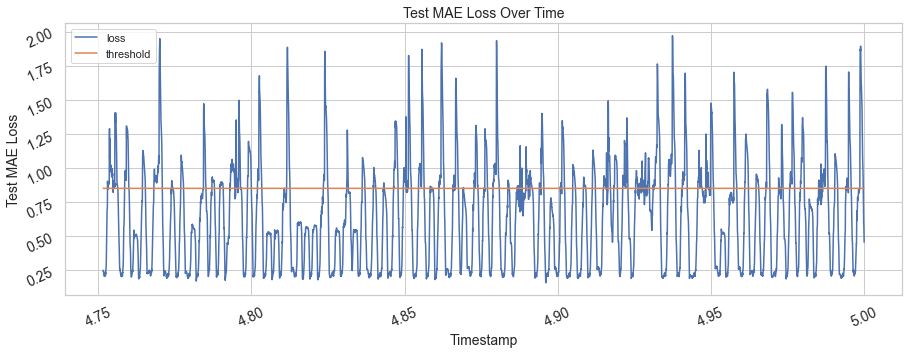

In [314]:
plt.figure(figsize=(15,5))
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25, fontsize=14)
plt.yticks(rotation=25, fontsize=14)

plt.title('Test MAE Loss Over Time', fontsize=14)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Test MAE Loss', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend();
plt.savefig('loss-threshold.png', dpi=300)

Now, we can see the actual plot of the anomalies that the LSTM model classified from the true data.

/Users/emanihunter/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


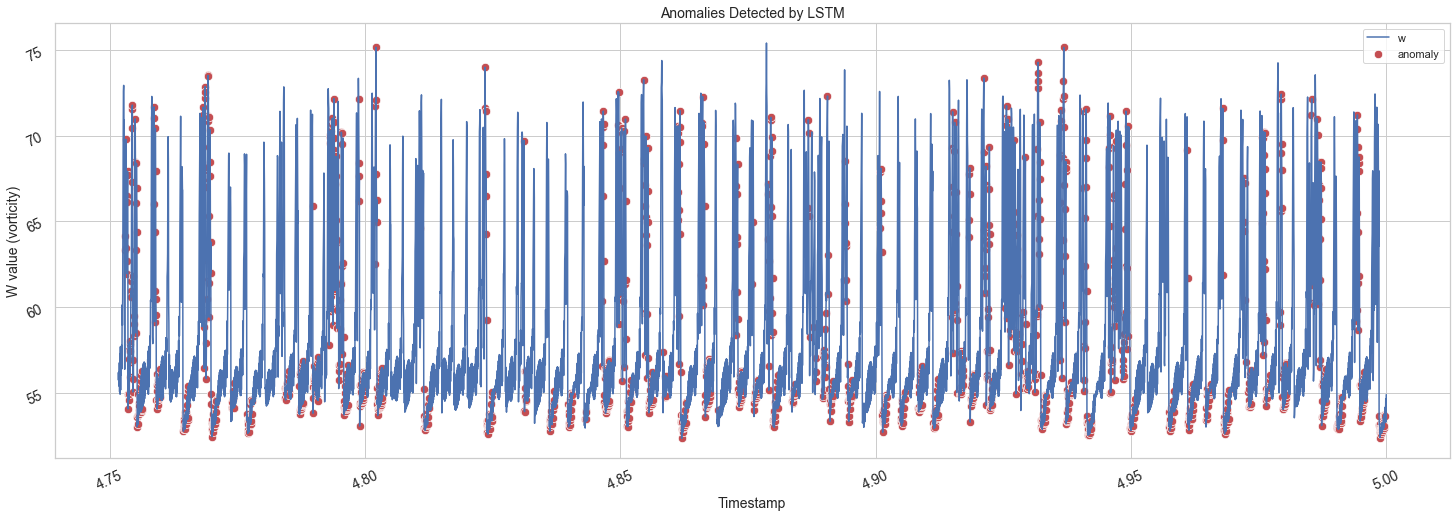

In [315]:
plt.figure(figsize=(25,8))
plt.plot(
  test.iloc[TIME_STEPS:].index, 
  scaler.inverse_transform(test.iloc[TIME_STEPS:].w.values.reshape(1,-1)).reshape(-1), 
  label='w'
)

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.w.values.reshape(1,-1)).reshape(-1),
  color=sns.color_palette()[3],
  s=70,
  label='anomaly'
)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(rotation=25, fontsize=14)
plt.title('Anomalies Detected by LSTM', fontsize=14)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('W value (vorticity)', fontsize=14)

plt.legend()
plt.savefig('anoms-detected-full.png', dpi=300)

Let's take a closer look at the first 5 time units to clearly see the data points/ patterns that were predicted as anomalies.

/Users/emanihunter/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


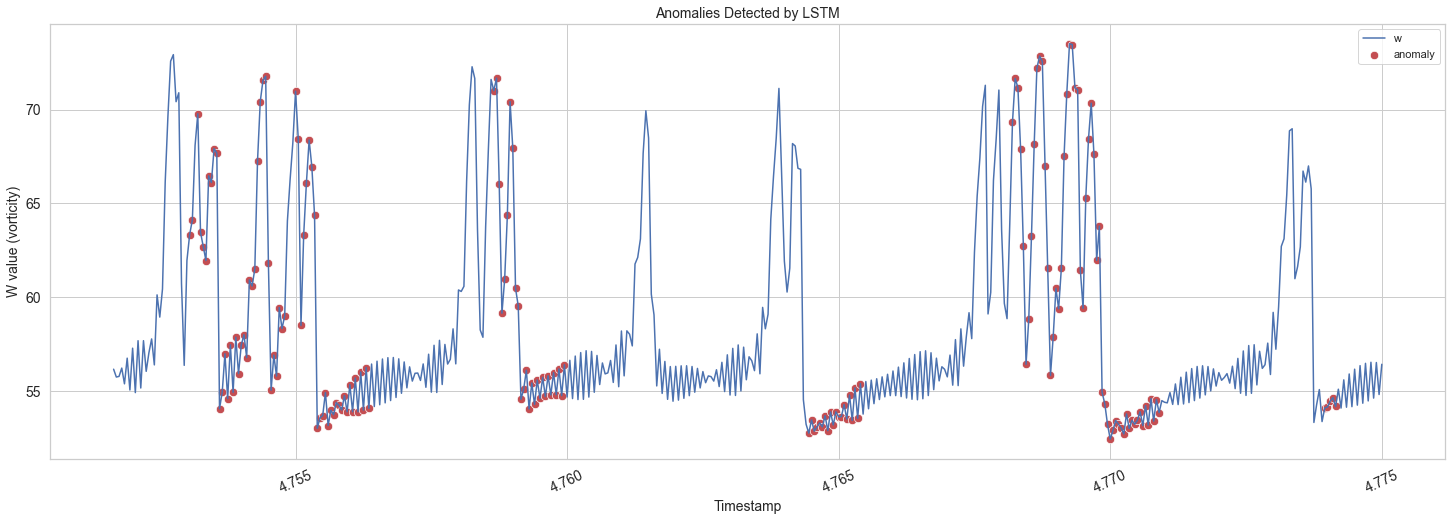

In [316]:
plt.figure(figsize=(25,8))
plt.plot(
  test.iloc[TIME_STEPS:500].index, 
  scaler.inverse_transform(test.iloc[TIME_STEPS:500].w.values.reshape(1,-1)).reshape(-1), 
  label='w'
)

sns.scatterplot(
  anomalies.iloc[:170].index,
  scaler.inverse_transform(anomalies.iloc[:170].w.values.reshape(1,-1)).reshape(-1),
  color=sns.color_palette()[3],
  s=70,
  label='anomaly'
)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Anomalies Detected by LSTM", fontsize=14)
plt.ylabel('W value (vorticity)', fontsize=14)
plt.xlabel("Timestamp",fontsize=14)
plt.legend()
plt.savefig("anoms.png", dpi=300)

#### Performance Metrics

We will evaluate the performance of the LSTM to see if the model predicted similar patterns/ anomalies that ANL visually classified. 

First, we will start by creating a dataframe of the test MAE loss and the true anomaly label that ANL provided.

In [317]:
error_df = pd.DataFrame({'Reconstruction_error': test_mae_loss.flatten().tolist(), 
                         'True_val': state[train_size:len(state)][TIME_STEPS:].tolist()})

In [318]:
error_df

Reconstruction_error  True_val
0                 0.249288       0.0
1                 0.237568       0.0
2                 0.241659       0.0
3                 0.224091       0.0
4                 0.218951       0.0
...                    ...       ...
4962              0.652474       0.0
4963              0.592392       0.0
4964              0.575963       0.0
4965              0.526192       0.0
4966              0.454535       0.0

[4967 rows x 2 columns]

Next, we will grab the predicted anomalies (where test MAE > threshold of 0.85) and create a confusion matrix from the true class labels and the predicted LSTM data points.

In [319]:
pred_state = []
for error in error_df["Reconstruction_error"].values:
    if error > THRESHOLD:
        pred_state.append(1)
    else:
        pred_state.append(0)
cm = confusion_matrix(error_df["True_val"], pred_state)

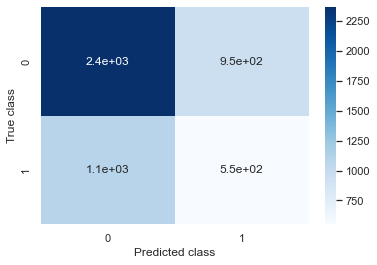

In [320]:
sns.heatmap(cm, cmap='Blues',annot=True)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('confusion-matrix.png', dpi=300)

We can see that there were quite a few True Positives but also quite a few False Negatives, where data points that were not labeled as anomalous were predicted as anomalies through the LSTM model. 

Let's calculate the accuracy score of the LSTM's predicted values and the data's true values.

In [322]:
acc_score = accuracy_score(error_df["True_val"], pred_state)
acc_score 

0.5878800080531508

The accuracy score of the LSTM Autoencoder was about 58.79%. This raises the question of whether this is a good performance metric to evaluate.

The accuracy score is quite lower than expected and it is advised that this particular technique is further explored. One idea for further exploration is to separate the data based on the class label, and using the data points that were considered 'normal' by ANL as the training data, predict the patterns of the 'normal' data and test on the anomalous data points.